In [26]:
#using Pkg; Pkg.add("Plots")

In [2]:
using Pkg; Pkg.add(["Flux","MLDatasets","CUDA","BSON","ProgressMeter","TensorBoardLogger"])
GC.gc()

In [3]:
using Pkg; Pkg.add(["FileIO","Images","ImageMagick"])
GC.gc()

In [4]:
## Classification of MNIST dataset 
## with the convolutional neural network known as LeNet5.
## This script also combines various
## packages from the Julia ecosystem with Flux.
using Flux
using Flux.Data: DataLoader
using Flux.Optimise: Optimiser, WeightDecay
using Flux: onehotbatch, onecold
using Flux.Losses: logitcrossentropy
using Statistics, Random
using Logging: with_logger
using TensorBoardLogger: TBLogger, tb_overwrite, set_step!, set_step_increment!
using ProgressMeter: @showprogress
import MLDatasets
import BSON

using Images, FileIO

GC.gc()

In [5]:
function get_data()
abs = pwd()

    normal_train = abs*"/chest_xray/train/NORMAL/".*readdir(abs*"/chest_xray/train/NORMAL")[1:30]
	pneumonia_train = abs*"/chest_xray/train/PNEUMONIA/".*readdir(abs*"/chest_xray/train/PNEUMONIA")[1:30]

    normal_test = abs*"/chest_xray/test/NORMAL/".*readdir(abs*"/chest_xray/test/NORMAL")[1:30]
	pneumonia_test = abs*"/chest_xray/test/PNEUMONIA/".*readdir(abs*"/chest_xray/test/PNEUMONIA")[1:30]

    xtrain = [normal_train;pneumonia_train]
    xtest = [normal_test;pneumonia_test]



#md"#  Creating Labels "

p_train_labels = labels(xtrain,"PNEUMONIA","pneumonia")
normal_train_labels=labels(xtrain,"NORMAL","normal")

p_test_labels=labels(xtest,"PNEUMONIA","pneumonia")
normal_test_labels=labels(xtest,"NORMAL","normal")


ytrain=vcat(normal_train_labels,p_train_labels)

ytest=vcat(normal_test_labels,p_test_labels)

    

xtrain =  [process_image.(x) for x in  xtrain]


xtest =  [process_image.(x) for x in  xtest]

    
Dict(:xtrain => xtrain,:xtest =>xtest ,:ytrain => ytrain ,:ytest =>ytest)
end

get_data (generic function with 1 method)

In [25]:
## utility functions
num_params(model) = sum(length, Flux.params(model)) 
round4(x) = round(x, digits=4)


#accepts array (v) and string(str), returns array of specified string with the length of str found in v
function labels(v,str,rturn=str)
    temp = []
    for (indx,i) in enumerate(v)
        if occursin(str,v[indx])
            push!(temp,rturn)
        end
    end
    return temp
end

#gets path, loads image,converts it to gray,resize it to 32*32 and float, then reshapes it to match model input
function process_image(path)
    img = load(path)
    img = Gray.(img)
    img = imresize(img,(32,32))
    img = Flux.unsqueeze(Float32.(img), 3)
    
    return img
end


process_image (generic function with 1 method)

In [7]:
function process_data()
    
#combine xtrain images into one array
xtrain = get_data()[:xtrain]
v= xtrain[1] #add first image
for i in 2:length(xtrain) #start from the 2nd image
   v = hcat(v,xtrain[i])
end

xtrain = reshape(v,32,32,1,:)

#do the same for xtest
xtest = get_data()[:xtest]
v2= xtest[1]
for i in 2:length(xtest)
   v2 = hcat(v2,xtest[i])
end

xtest = reshape(v2,32,32,1,:)



ytrain = get_data()[:ytrain]
ytest = get_data()[:ytest]
    
ytrain, ytest = onehotbatch(ytrain, ["normal","pneumonia"]), onehotbatch(ytest, ["normal","pneumonia"])

    train_loader = DataLoader((xtrain,ytrain), shuffle=true,batchsize=2)
    test_loader = DataLoader((xtest,ytest),  batchsize=2)


    #train_loader = DataLoader((xtrain, ytrain), batchsize=args.batchsize, shuffle=true)
    #test_loader = DataLoader((xtest, ytest),  batchsize=args.batchsize)
    
    return train_loader, test_loader
end

process_data (generic function with 1 method)

In [ ]:
## for the purpose of mosaicview, these vars are global

abs = pwd()

    normal_train = abs*"/chest_xray/train/NORMAL/".*readdir(abs*"/chest_xray/train/NORMAL")[1:30]
	pneumonia_train = abs*"/chest_xray/train/PNEUMONIA/".*readdir(abs*"/chest_xray/train/PNEUMONIA")[1:30]

    normal_test = abs*"/chest_xray/test/NORMAL/".*readdir(abs*"/chest_xray/test/NORMAL")[1:30]
	pneumonia_test = abs*"/chest_xray/test/PNEUMONIA/".*readdir(abs*"/chest_xray/test/PNEUMONIA")[1:30]

    xtrain = [normal_train;pneumonia_train]
    xtest = [normal_test;pneumonia_test]

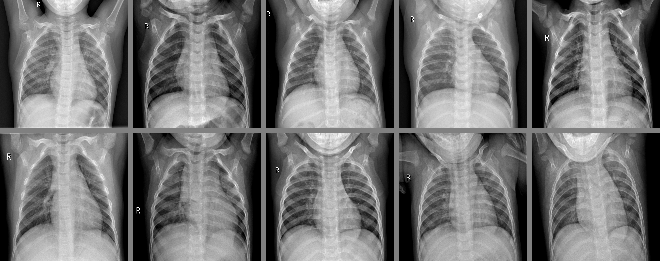

In [57]:
#mosaicview(Xtrain)

mosaicview([imresize(load(x),128,128) for x in  [normal_train;pneumonia_train]][1:10]; fillvalue=0.5, npad=5, ncol=5, rowmajor=true)


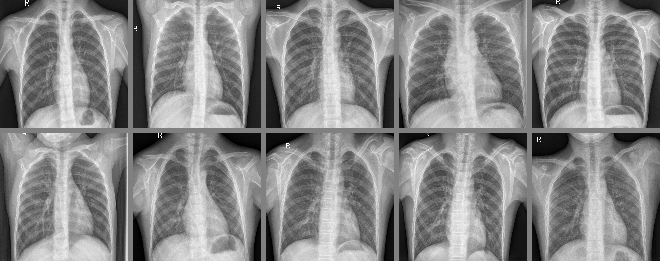

In [164]:

mosaicview([imresize(load(x),128,128) for x in  [pneumonia_test]][1:10]; fillvalue=0.5, npad=5, ncol=5, rowmajor=true)


In [8]:
# LeNet5 "constructor". 
# The model can be adapted to any image size
# and any number of output classes.
function LeNet5(; imgsize=(32,32,1), nclasses=2) 
    out_conv_size = (imgsize[1]÷4 - 3, imgsize[2]÷4 - 3, 16)
    
#=    return Chain(
            Conv((5, 5), imgsize[end]=>6, relu),#stride=1, pad=0, dilation=1
            MaxPool((2, 2)),
            Conv((5, 5), 6=>16, relu),
            MaxPool((2, 2)),
            flatten,
            Dense(prod(out_conv_size), 120, relu), 
            Dense(120, 84, relu), 
            Dense(84, nclasses)
          )
    =#
   
    return Chain(
        Conv((5, 5), imgsize[end]=>6, tanh),#; stride=1, pad=2), #just trying to modify pads manually 
            MeanPool((2, 2)),
            Conv((5, 5), 6=>16, tanh),
            MeanPool((2, 2)),
            flatten,
            Dense(prod(out_conv_size), 120, tanh), 
            Dense(120, 84, tanh), 
            Dense(84, 2), softmax
          )
    
    
end

LeNet5 (generic function with 1 method)

In [9]:
loss(ŷ, y) = logitcrossentropy(ŷ, y)

loss (generic function with 1 method)

In [10]:
function eval_loss_accuracy(loader, model)
    l = 0f0
    acc = 0
    ntot = 0
    for (x, y) in loader
        ŷ = model(x)
        l += loss(ŷ, y) * size(x)[end]        
        acc += sum(onecold(ŷ) .== onecold(y))
        ntot += size(x)[end]
    end
    return (loss = l/ntot |> round4, acc = acc/ntot*100 |> round4)
end

eval_loss_accuracy (generic function with 1 method)

In [22]:
function train(; kws...)
    #args = Args(; kws...)
    #args.seed > 0 && Random.seed!(args.seed)
   
      #η = 3e-4             # learning rate
    λ = 0                # L2 regularizer param, implemented as weight decay
    #batchsize = 2      # batch size
    epochs = 10          # number of epochs
    seed = 0             # set seed > 0 for reproducibility
    infotime = 1 	     # report every `infotime` epochs
    checktime = 5        # Save the model every `checktime` epochs. Set to 0 for no checkpoints.
    #tblogger = true      # log training with tensorboard
    savepath = "models/"    # results path
    
    
    ## DATA
    #train_loader, test_loader = process_data(args)
    @info "Dataset MNIST: $(train_loader.nobs) train and $(test_loader.nobs) test examples"

    ## MODEL AND OPTIMIZER
    model = LeNet5() 
    @info "LeNet5 model: $(num_params(model)) trainable params"    
    
    ps = Flux.params(model)  

    opt = ADAM(3e-4) 
    if λ > 0 # add weight decay, equivalent to L2 regularization
        opt = Optimiser(WeightDecay(λ), opt)
    end
   
    
    ## LOGGING UTILITIES
    #if args.tblogger 
        tblogger = TBLogger(savepath, tb_overwrite)
        set_step_increment!(tblogger, 0) # 0 auto increment since we manually set_step!
        #@info "TensorBoard logging at \"$(savepath)\""
    #end
    
        function report(epoch)
        train = eval_loss_accuracy(train_loader, model)
        test = eval_loss_accuracy(test_loader, model)        
        println("Epoch: $epoch   Train: $(train)   Test: $(test)")
        
     #   if args.tblogger
            set_step!(tblogger, epoch)
            with_logger(tblogger) do
                @info "train" loss=train.loss  acc=train.acc
                @info "test"  loss=test.loss   acc=test.acc
            end
      #  end
    end
    
    
    ## TRAINING
    @info "Start Training"
    report(0)
    for epoch in 1:epochs
        @showprogress for (x, y) in train_loader
            gs = Flux.gradient(ps) do
                    ŷ = model(x)
                    loss(ŷ, y)
                end

            Flux.Optimise.update!(opt, ps, gs)
        end
                
        ## Printing and logging
        epoch % infotime == 0 && report(epoch)
        if checktime > 0 && epoch % checktime == 0
            !ispath(savepath) && mkpath(savepath)
            modelpath = joinpath(savepath, "model.bson") 
            let model = cpu(model) #return model to cpu before serialization
                BSON.@save modelpath model epoch
            end
            @info "Model saved in \"$(modelpath)\""
        end
    end
end



train (generic function with 1 method)

In [14]:
train_loader, test_loader = process_data()

(DataLoader{Tuple{Array{Float32, 4}, Flux.OneHotArray{UInt32, 2, 1, 2, Vector{UInt32}}}, Random._GLOBAL_RNG}((Float32[0.07450981 0.27450982 … 0.627451 0.3647059; 0.06666667 0.23529412 … 0.4 0.34901962; … ; 0.1254902 0.105882354 … 0.08235294 0.08235294; 0.101960786 0.101960786 … 0.14901961 0.16862746]

Float32[0.12156863 0.1882353 … 0.15686275 0.10980392; 0.11764706 0.2 … 0.15294118 0.09411765; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.17254902 … 0.20784314 0.09803922; 0.0 0.11764706 … 0.18431373 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.21960784 0.19607843 … 0.2901961 0.21176471; 0.20784314 0.23137255 … 0.32941177 0.27058825; … ; 0.050980393 0.31764707 … 0.22745098 0.07450981; 0.050980393 0.32941177 … 0.22352941 0.078431375]

Float32[0.11372549 0.18431373 … 0.46666667 0.25882354; 0.050980393 0.14509805 … 0.23921569 0.21960784; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.19607843 0.21568628 … 0.22352941 0.20392157; 0.19607843 0.23921569 … 0.2

In [23]:
train()

Epoch: 0   Train: (loss = 0.6933f0, acc = 51.6667)   Test: (loss = 0.6926f0, acc = 50.0)


┌ Info: Dataset MNIST: 60 train and 60 test examples
└ @ Main In[22]:18
┌ Info: LeNet5 model: 61026 trainable params
└ @ Main In[22]:22
┌ Info: Start Training
└ @ Main In[22]:55
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Epoch: 1   Train: (loss = 0.6622f0, acc = 86.6667)   Test: (loss = 0.6691f0, acc = 83.3333)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Epoch: 2   Train: (loss = 0.629f0, acc = 71.6667)   Test: (loss = 0.6358f0, acc = 88.3333)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Epoch: 3   Train: (loss = 0.5822f0, acc = 91.6667)   Test: (loss = 0.5882f0, acc = 90.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Epoch: 4   Train: (loss = 0.5277f0, acc = 86.6667)   Test: (loss = 0.5372f0, acc = 85.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Epoch: 5   Train: (loss = 0.4989f0, acc = 81.6667)   Test: (loss = 0.5198f0, acc = 81.6667)


┌ Info: Model saved in "models/model.bson"
└ @ Main In[22]:75
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Epoch: 6   Train: (loss = 0.4636f0, acc = 88.3333)   Test: (loss = 0.4484f0, acc = 90.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Epoch: 7   Train: (loss = 0.4406f0, acc = 93.3333)   Test: (loss = 0.4519f0, acc = 90.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Epoch: 8   Train: (loss = 0.426f0, acc = 88.3333)   Test: (loss = 0.4192f0, acc = 90.0)
Epoch: 9   Train: (loss = 0.4087f0, acc = 91.6667)   Test: (loss = 0.4177f0, acc = 90.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Epoch: 10   Train: (loss = 0.4114f0, acc = 95.0)   Test: (loss = 0.4277f0, acc = 90.0)


┌ Info: Model saved in "models/model.bson"
└ @ Main In[22]:75


In [51]:
ytrain = nothing
xtrain = nothing
xtest = nothing
ytest = nothing
Xtrain = nothing
Xtest = nothing
GC.gc()

In [24]:
#performance check:: global vars vs global args


#@time get_data(Args()) #1#vars: 11.778837 seconds (24.59 k allocations: 1.094 GiB, 1.33% gc time)
#2# global: 13.794977 seconds (50.42 k allocations: 1.095 GiB, 1.61% gc time, 0.51% compilation time)
#global:  17.755804 seconds (24.59 k allocations: 1.094 GiB, 0.60% gc time)
#normal: 13.487243 seconds (50.45 k allocations: 1.095 GiB, 1.33% gc time, 0.57% compilation time)
@time train_loader, test_loader = process_data()

 36.151788 seconds (80.52 k allocations: 4.386 GiB, 0.86% gc time)


(DataLoader{Tuple{Array{Float32, 4}, Flux.OneHotArray{UInt32, 2, 1, 2, Vector{UInt32}}}, Random._GLOBAL_RNG}((Float32[0.07450981 0.27450982 … 0.627451 0.3647059; 0.06666667 0.23529412 … 0.4 0.34901962; … ; 0.1254902 0.105882354 … 0.08235294 0.08235294; 0.101960786 0.101960786 … 0.14901961 0.16862746]

Float32[0.12156863 0.1882353 … 0.15686275 0.10980392; 0.11764706 0.2 … 0.15294118 0.09411765; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.17254902 … 0.20784314 0.09803922; 0.0 0.11764706 … 0.18431373 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.21960784 0.19607843 … 0.2901961 0.21176471; 0.20784314 0.23137255 … 0.32941177 0.27058825; … ; 0.050980393 0.31764707 … 0.22745098 0.07450981; 0.050980393 0.32941177 … 0.22352941 0.078431375]

Float32[0.11372549 0.18431373 … 0.46666667 0.25882354; 0.050980393 0.14509805 … 0.23921569 0.21960784; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.19607843 0.21568628 … 0.22352941 0.20392157; 0.19607843 0.23921569 … 0.2